# Analysis of [Compass](https://github.com/YosefLab/Compass) results

In [1]:
# taken from https://github.com/YosefLab/Compass/blob/docs/notebooks/compass_analysis.py
import pandas as pd
import numpy as np
from scipy.stats import wilcoxon, mannwhitneyu, ranksums
from statsmodels.stats.multitest import multipletests
import matplotlib.pyplot as plt
import scipy.cluster.hierarchy as hcluster
from scipy.spatial.distance import squareform

def cohens_d(x, y):
    pooled_std = np.sqrt(((len(x)-1) * np.var(x, ddof=1) 
                          + (len(y)-1) * np.var(y, ddof=1)) / 
                             (len(x) + len(y) - 2))
    return (np.mean(x) - np.mean(y)) / pooled_std
    

def wilcoxon_test(consistencies_matrix, group_A_cells, group_B_cells):
    """
        Performs an unpaired wilcoxon test (or mann-whitney U test) for each reaction between group_A and group_B
    """
    #per reaction/meta-reaction, conduct wilcoxon test between group_A and group_B
    group_A = consistencies_matrix.loc[:,group_A_cells]
    group_B = consistencies_matrix.loc[:,group_B_cells]
    results = pd.DataFrame(index = consistencies_matrix.index, columns = ['wilcox_stat', 'wilcox_pval', 'cohens_d'], dtype='float64')
    for rxn in consistencies_matrix.index:
        A, B = group_A.loc[rxn].to_numpy().ravel(), group_B.loc[rxn].to_numpy().ravel()
        stat, pval = mannwhitneyu(A, B, alternative='two-sided')
        c_d = cohens_d(A, B)
        results.loc[rxn, ['wilcox_stat', 'wilcox_pval', 'cohens_d']] = stat, pval, c_d
    results['adjusted_pval'] = np.array(multipletests(results['wilcox_pval'], method='fdr_bh')[1], dtype='float64')
    return results

def get_reaction_consistencies(compass_reaction_penalties, min_range=1e-3):
    """
        Converts the raw penalties outputs of compass into scores per reactions where higher numbers indicate more activity
    """
    df = -np.log(compass_reaction_penalties + 1)
    df = df[df.max(axis=1) - df.min(axis=1) >= min_range]
    df = df - df.min().min()
    return df

def get_metareactions(reactions, height=0.02):
    """
        Returns an array of metareaction labels for each reaction
        Index k in the returned array has the metareaction label for reaction k.
    """
    #pairwise_reaction_correlations = reactions.T.corr(method='spearman') #Pandas method here is orders of magnitude slower
    pairwise_reaction_correlations = np.corrcoef(reactions.rank(axis=1))
    #Unfortunately due to floating point issues, these matrices are not always perfectly symmetric and the diagonal may be slightly off from 1
    pairwise_reaction_correlations[np.arange(reactions.shape[0]), np.arange(reactions.shape[0])] = 1.0
    pairwise_reaction_correlations = (pairwise_reaction_correlations + pairwise_reaction_correlations.T)/2
    assert(np.all(pairwise_reaction_correlations == pairwise_reaction_correlations.T))

    Z = hcluster.complete(squareform(1 - pairwise_reaction_correlations))
    return hcluster.fcluster(Z, height, criterion='distance')

labeled_reactions = {}

relevant_subsystems = [
    'Fatty acid oxidation', 
    'Arachidonic acid metabolism',
    'Glycerophospholipid metabolism',
    'Sphingolipid metabolism',
    'Glycolysis', 
    'Oxidative phosphorylation',
    'Pyrimidine synthesis'
    'Pyrimidine catabolism'
    'beta-Alanine metabolism'
]

# custom functions
def load_reactions(disease_reactions_file, control_reactions_file, disease_label, control_label):
    ddf = pd.read_csv(
        disease_reactions_file,
        sep = '\t',
        index_col = 0,
        compression = 'gzip'
    )
    cdf = pd.read_csv(
        control_reactions_file,
        sep = '\t',
        index_col = 0,
        compression = 'gzip'
    )
    for df, label in zip([ddf, cdf], [disease_label, control_label]):
        df.columns = ['_'.join([label, column]) for column in df.columns]
        
    df = ddf.merge(
        cdf,
        how = 'left',
        left_index = True,
        right_index = True
    )
    return df

In [2]:
# only need to be run if you didn't download it yet
#!wget https://github.com/YosefLab/Compass/raw/docs/notebooks/extdata/RECON2/reaction_metadata.csv -O ../compass/recon2_reaction_metadata.csv

In [3]:
reaction_metadata = pd.read_csv(
    "../compass/recon2_reaction_metadata.csv", 
    index_col = 0
)
reaction_metadata

reaction_name  \
reaction_no_direction                                               
10FTHF5GLUtl               5-glutamyl-10FTHF transport, lysosomal   
10FTHF5GLUtm           5-glutamyl-10FTHF transport, mitochondrial   
10FTHF6GLUtl               6-glutamyl-10FTHF transport, lysosomal   
10FTHF6GLUtm           6-glutamyl-10FTHF transport, mitochondrial   
10FTHF7GLUtl               7-glutamyl-10FTHF transport, lysosomal   
...                                                           ...   
MAL_Lte                                     Transport of L-malate   
OROTGLUt                                                 OROTGLUt   
PNTOte                              Transport of (R)-Pantothenate   
IDOURte                      L-iduronate transport, extracellular   
EX_idour(e)                               Exchange of L-iduronate   

                                                                 formula  \
reaction_no_direction                                                      
10FTHF5GLUtl           1.00 * 10-formyltetrahydrofolate-[Glu](5) [c] ...   
10FTHF5GLUtm           1.00 * 10-formyltetrahydrofolate-[Glu](5) [m] ...   
10FTHF6GLUtl           1.00 * 10-formyltetrahydrofolate-[Glu](6) [c] ...   
10FTHF6GLUtm           1.00 * 10-formyltetrahydrofolate-[Glu](6) [m] ...   
10FTHF7GLUtl           1.00 * 10-formyltetrahydrofolate-[Glu](7) [c] ...   
...                                                                  ...   
MAL_Lte                1.00 * (S)-malate(2-) [e] --> 1.00 * (S)-malat...   
OROTGLUt               1.00 * L-glutamate(1-) [c] + 1.00 * Orotate [e...   
PNTOte                 1.00 * (R)-Pantothenate [e] --> 1.00 * (R)-Pan...   
IDOURte                1.00 * L-iduronate [e] --> 1.00 * L-iduronate ...   
EX_idour(e)                       1.00 * L-iduronate [e] --> ϕ\nNo genes   

                      associated_genes                 subsystem EC_number  \
reaction_no_direction                                                        
10FTHF5GLUtl                       NaN      Transport, lysosomal       NaN   
10FTHF5GLUtm                       NaN  Transport, mitochondrial       NaN   
10FTHF6GLUtl                       NaN      Transport, lysosomal       NaN   
10FTHF6GLUtm                       NaN  Transport, mitochondrial       NaN   
10FTHF7GLUtl                       NaN      Transport, lysosomal       NaN   
...                                ...                       ...       ...   
MAL_Lte                            NaN  Transport, extracellular       NaN   
OROTGLUt                       SLC22A7  Transport, extracellular       NaN   
PNTOte                             NaN  Transport, extracellular       NaN   
IDOURte                            NaN  Transport, extracellular       NaN   
EX_idour(e)                        NaN  Exchange/demand reaction       NaN   

                       confidence  
reaction_no_direction              
10FTHF5GLUtl                  2.0  
10FTHF5GLUtm                  2.0  
10FTHF6GLUtl                  2.0  
10FTHF6GLUtm                  2.0  
10FTHF7GLUtl                  2.0  
...                           ...  
MAL_Lte                       NaN  
OROTGLUt                      NaN  
PNTOte                        NaN  
IDOURte                       NaN  
EX_idour(e)                   NaN  

[7440 rows x 6 columns]

In [4]:
reaction_metadata[
    reaction_metadata.associated_genes.apply(lambda x: x.startswith('SLC7A5') if type(x) == str else False)
]

reaction_name  \
reaction_no_direction                                                      
r1544                  Amino Acid-Polyamine-Organocation (APC) TCDB:2...   
r1546                  Amino Acid-Polyamine-Organocation (APC) TCDB:2...   
r1547                  Amino Acid-Polyamine-Organocation (APC) TCDB:2...   
r1548                  Amino Acid-Polyamine-Organocation (APC) TCDB:2...   
r1549                  Amino Acid-Polyamine-Organocation (APC) TCDB:2...   
...                                                                  ...   
r1658                  Amino Acid-Polyamine-Organocation (APC) TCDB:2...   
r1659                  Amino Acid-Polyamine-Organocation (APC) TCDB:2...   
r1660                  Amino Acid-Polyamine-Organocation (APC) TCDB:2...   
r1661                  Amino Acid-Polyamine-Organocation (APC) TCDB:2...   
r1662                  Amino Acid-Polyamine-Organocation (APC) TCDB:2...   

                                                                 formula  \
reaction_no_direction                                                      
r1544                  1.00 * L-glutamine [c] + 1.00 * Glycine [e] --...   
r1546                  1.00 * Glycine [e] + 1.00 * L-methionine [c] -...   
r1547                  1.00 * Glycine [e] + 1.00 * L-tryptophan [c] -...   
r1548                  1.00 * Glycine [e] + 1.00 * L-phenylalanine [c...   
r1549                  1.00 * Glycine [e] + 1.00 * L-tyrosine [c] -->...   
...                                                                  ...   
r1658                  1.00 * L-valine [e] + 1.00 * L-homoserine [c] ...   
r1659                  1.00 * L-valine [e] + 1.00 * L-isoleucine [c] ...   
r1660                  1.00 * L-threonine [e] + 1.00 * L-homoserine [...   
r1661                  1.00 * L-threonine [e] + 1.00 * L-isoleucine [...   
r1662                  1.00 * L-homoserine [e] + 1.00 * L-isoleucine ...   

                      associated_genes                 subsystem EC_number  \
reaction_no_direction                                                        
r1544                           SLC7A5  Transport, extracellular       NaN   
r1546                           SLC7A5  Transport, extracellular       NaN   
r1547                           SLC7A5  Transport, extracellular       NaN   
r1548                           SLC7A5  Transport, extracellular       NaN   
r1549                           SLC7A5  Transport, extracellular       NaN   
...                                ...                       ...       ...   
r1658                           SLC7A5  Transport, extracellular       NaN   
r1659                           SLC7A5  Transport, extracellular       NaN   
r1660                           SLC7A5  Transport, extracellular       NaN   
r1661                           SLC7A5  Transport, extracellular       NaN   
r1662                           SLC7A5  Transport, extracellular       NaN   

                       confidence  
reaction_no_direction              
r1544                         0.0  
r1546                         0.0  
r1547                         0.0  
r1548                         0.0  
r1549                         0.0  
...                           ...  
r1658                         0.0  
r1659                         0.0  
r1660                         0.0  
r1661                         0.0  
r1662                         0.0  

[111 rows x 6 columns]

In [5]:
np.sort(reaction_metadata.subsystem.unique())

array(['Alanine and aspartate metabolism', 'Alkaloid synthesis',
       'Aminosugar metabolism',
       'Androgen and estrogen synthesis and metabolism',
       'Arachidonic acid metabolism', 'Arginine and Proline Metabolism',
       'Bile acid synthesis', 'Biotin metabolism',
       'Blood group synthesis', 'Butanoate metabolism',
       'C5-branched dibasic acid metabolism', 'Cholesterol metabolism',
       'Chondroitin sulfate degradation', 'Chondroitin synthesis',
       'Citric acid cycle', 'CoA catabolism', 'CoA synthesis',
       'Cysteine Metabolism', 'Cytochrome metabolism',
       'D-alanine metabolism', 'Dietary fiber binding',
       'Eicosanoid metabolism', 'Exchange/demand reaction',
       'Fatty acid oxidation', 'Fatty acid synthesis',
       'Folate metabolism', 'Fructose and mannose metabolism',
       'Galactose metabolism', 'Glutamate metabolism',
       'Glutathione metabolism', 'Glycerophospholipid metabolism',
       'Glycine, serine, alanine and threonine metabo

In [24]:
reaction_metadata[
    reaction_metadata.subsystem.isin(relevant_subsystems) &
    reaction_metadata.confidence.isin([0, 4]) 
]

reaction_name  \
reaction_no_direction                                                      
3DSPHR                                    3-Dehydrosphinganine reductase   
A4GALTc                   Lactosylceramide 4-alpha-galactosyltransferase   
A4GALTg                   Lactosylceramide 4-alpha-galactosyltransferase   
ACACT4p                acetyl-CoA C-acetyltransferase (octanoyl-CoA),...   
ACACT5p                acetyl-CoA C-acyltransferase (decanoyl-CoA), p...   
...                                                                  ...   
OCTDECCPT2             transport of Octadecenoyl-CoA into mitochondri...   
SBCOAACOTx             thioesterification of suberyl coa for release ...   
SEBCOAPET              thioesterification of sebacoylcoa for release ...   
SUCCOAPET              thioesterification of succinyl coa for release...   
FADH2ETC                       Complex II reaction for respiratory chain   

                                                                 formula  \
reaction_no_direction                                                      
3DSPHR                 1.00 * proton [c] + 1.00 * Nicotinamide adenin...   
A4GALTc                1.00 * galactosyl glucosyl ceramide [c] + 1.00...   
A4GALTg                1.00 * galactosyl glucosyl ceramide [g] + 1.00...   
ACACT4p                1.00 * Coenzyme A [x] + 1.00 * 3-Oxodecanoyl-C...   
ACACT5p                1.00 * Coenzyme A [x] + 1.00 * 3-Oxododecanoyl...   
...                                                                  ...   
OCTDECCPT2             1.00 * Coenzyme A [m] + 1.00 * octadecenoyl ca...   
SBCOAACOTx             1.00 * Water [x] + 1.00 * suberylcoa [x] --> 1...   
SEBCOAPET              1.00 * Water [x] + 1.00 * sebacoylcoa [x] --> ...   
SUCCOAPET              1.00 * Water [x] + 1.00 * Succinyl-CoA [x] -->...   
FADH2ETC               1.00 * Flavin adenine dinucleotide reduced [m]...   

                        associated_genes                  subsystem  \
reaction_no_direction                                                 
3DSPHR                              KDSR    Sphingolipid metabolism   
A4GALTc                           A4GALT    Sphingolipid metabolism   
A4GALTg                           A4GALT    Sphingolipid metabolism   
ACACT4p                           ACAA1B       Fatty acid oxidation   
ACACT5p                           ACAA1B       Fatty acid oxidation   
...                                  ...                        ...   
OCTDECCPT2                          CPT2       Fatty acid oxidation   
SBCOAACOTx                         ACOT8       Fatty acid oxidation   
SEBCOAPET                          ACOT8       Fatty acid oxidation   
SUCCOAPET                   ACOT4; ACOT8       Fatty acid oxidation   
FADH2ETC               ETFA; ETFB; ETFDH  Oxidative phosphorylation   

                       EC_number  confidence  
reaction_no_direction                         
3DSPHR                 1.1.1.102         4.0  
A4GALTc                2.4.1.228         4.0  
A4GALTg                2.4.1.228         4.0  
ACACT4p                 2.3.1.16         4.0  
ACACT5p                 2.3.1.16         4.0  
...                          ...         ...  
OCTDECCPT2                   NaN         4.0  
SBCOAACOTx                   NaN         4.0  
SEBCOAPET                    NaN         4.0  
SUCCOAPET                    NaN         4.0  
FADH2ETC                     NaN         4.0  

[972 rows x 6 columns]

## scRNA results

In [20]:
quantifications = ['novarino_tpm', 'salmon_tpm', 'featureCounts_tpm']
reaction_penalties = {}
for quant in quantifications:
    filepaths = {
        'astrocytes': [
            f'../compass/{quant}/astrocytes_wt',
            f'../compass/{quant}/astrocytes_ko'
        ],
        'neurons': [
            f'../compass/{quant}/neurons_wt',
            f'../compass/{quant}/neurons_ko'
        ],
        'olfactory_cells': [
            f'../compass/{quant}/olfactory_cells_wt',
            f'../compass/{quant}/olfactory_cells_ko'
        ],
        'oligodendrytes': [
            f'../compass/{quant}/oligodendrytes_wt',
            f'../compass/{quant}/oligodendrytes_ko'
        ]
    }
    labels = {
        key: ['WT', 'KO'] for key in filepaths.keys()
    }
    reaction_penalties[quant] = {
        key: load_reactions(
            *['/'.join([path, 'reactions.tsv.gz']) for path in paths],
            *labels[key]
        ) for key, paths in filepaths.items()
    }

In [53]:
# join reaction penalties with metadata for filtering
single_rxn_penalties = reaction_penalties['novarino_tpm']['neurons'].copy()
for r in single_rxn_penalties.index:
    if r in reaction_metadata.index:
        single_rxn_penalties.loc[r, 'metadata_r_id'] = r
    elif r[:-4] in reaction_metadata.index:
        single_rxn_penalties.loc[r, 'metadata_r_id'] = r[:-4]
    else:
        print("Should not occur")
single_rxn_penalties = single_rxn_penalties.merge(
    reaction_metadata, 
    how = 'left',
    left_on = 'metadata_r_id', 
    right_index = True, 
    validate = 'm:1'
)
single_rxn_penalties = single_rxn_penalties.loc[
    single_rxn_penalties.confidence.isin([0, 4]) &
    single_rxn_penalties.subsystem.isin(relevant_subsystems),
    single_rxn_penalties.columns.str.match('^WT|^KO')
]
single_rxn_penalties

WT_wt_162325  WT_wt_162326  WT_wt_162328  WT_wt_162329  \
3DSPHR_pos    6446.011911   6621.153771   6482.628147   5941.067496   
A4GALTc_pos      0.000000      0.000000      0.000000      0.000000   
A4GALTg_pos   3664.439708   3716.360749   3719.207034   3448.541864   
ACACT4p_pos  26545.993025  22802.983807  25642.189253  22292.339090   
ACACT5p_pos  26545.993025  22802.983807  25642.189253  22292.339090   
...                   ...           ...           ...           ...   
r1451_pos    23031.694144  21311.010630  20167.702594  17575.304682   
r1487_neg        0.000000      0.000000      0.000000      0.000000   
r1487_pos    16740.194858  15796.844162  16463.849871  14315.874261   
r1488_neg        0.000000      0.000000      0.000000      0.000000   
r1488_pos    13424.356160  12907.502325  13379.959822  11804.488238   

             WT_wt_162338  WT_wt_162341  WT_wt_162343  WT_wt_162423  \
3DSPHR_pos    6435.176973   6996.206030   6264.239252   6362.080905   
A4GALTc_pos      0.000000      0.000000      0.000000      0.000000   
A4GALTg_pos   3729.467973   3882.172155   3411.536504   3460.053877   
ACACT4p_pos  21190.206415  24493.725584  19103.171720  20153.646765   
ACACT5p_pos  21190.206415  24493.725584  19103.171720  20153.646765   
...                   ...           ...           ...           ...   
r1451_pos    18904.231430  21099.583634  21983.773994  21620.671650   
r1487_neg        0.000000      0.000000      0.000000      0.000000   
r1487_pos    15213.563716  16575.829571  14971.694714  14715.544183   
r1488_neg        0.000000      0.000000      0.000000      0.000000   
r1488_pos    12477.781759  13480.498499  12132.148700  12000.785050   

             WT_wt_162438  WT_wt_162455  ...  KO_ko_162490  KO_ko_162503  \
3DSPHR_pos    6130.924348   5632.742831  ...   6322.502688   6030.083764   
A4GALTc_pos      0.000000      0.000000  ...      0.000000      0.000000   
A4GALTg_pos   3481.524228   3218.247097  ...   3614.632116   3428.764029   
ACACT4p_pos  24930.502471  22037.459523  ...  22785.494303  22468.513989   
ACACT5p_pos  24930.502471  22037.459523  ...  22785.494303  22468.513989   
...                   ...           ...  ...           ...           ...   
r1451_pos    20345.145758  20029.296726  ...  22184.813988  21495.875117   
r1487_neg        0.000000      0.000000  ...      0.000000      0.000000   
r1487_pos    15151.860666  14184.743938  ...  15036.480984  14545.075702   
r1488_neg        0.000000      0.000000  ...      0.000000      0.000000   
r1488_pos    12211.639442  11641.106593  ...  12409.345173  11799.497392   

             KO_ko_162519  KO_ko_162520  KO_ko_162521  KO_ko_162523  \
3DSPHR_pos    6639.245909   6913.609298   6169.575926   6954.826052   
A4GALTc_pos      0.000000      0.000000      0.000000      0.000000   
A4GALTg_pos   3580.530774   3841.429231   3357.662677   3871.042596   
ACACT4p_pos  21134.021871  28595.781388  19335.448308  26567.685709   
ACACT5p_pos  21134.021871  28595.781388  19335.448308  26567.685709   
...                   ...           ...           ...           ...   
r1451_pos    21435.364966  23766.984287  16772.127000  22642.478498   
r1487_neg        0.000000      0.000000      0.000000      0.000000   
r1487_pos    14924.766480  16691.631223  14375.459239  17021.601812   
r1488_neg        0.000000      0.000000      0.000000      0.000000   
r1488_pos    12301.447188  13722.320475  11793.114406  13753.513465   

             KO_ko_162534  KO_ko_162551  KO_ko_162553  KO_ko_162554  
3DSPHR_pos    6704.587807   6426.362277   5866.293092   5797.118628  
A4GALTc_pos      0.000000      0.000000      0.000000      0.000000  
A4GALTg_pos   3759.147139   3660.249194   3435.127632   3278.371470  
ACACT4p_pos  26018.336919  24088.889687  24132.851569  20776.139965  
ACACT5p_pos  26018.336919  24088.889687  24132.851569  20776.139965  
...                   ...           ...           ...           ...  
r1451_pos    21927.332004  23347.566404  18389.3177

In [56]:
# aggregate meta reactions
# see also https://yoseflab.github.io/Compass/notebooks/Demo.html#Metareactions
tmp_rxn_penalties = single_rxn_penalties.copy()
tmp_rxn_penalties[tmp_rxn_penalties <= 1e-4] = 0
tmp_rxn_penalties = tmp_rxn_penalties[
    np.all(tmp_rxn_penalties != 0, axis=1)
]
tmp_rxn_penalties = tmp_rxn_penalties[
    tmp_rxn_penalties.max(axis=1) - tmp_rxn_penalties.min(axis=1) != 0
]
meta_rxns_map = get_metareactions(tmp_rxn_penalties)
meta_rxn_penalties = tmp_rxn_penalties.join(
    pd.DataFrame(
        meta_rxns_map, 
        columns=["meta_rxn_id"], 
        index = tmp_rxn_penalties.index
    )
).groupby("meta_rxn_id").mean()
meta_rxn_penalties

WT_wt_162325  WT_wt_162326  WT_wt_162328  WT_wt_162329  \
meta_rxn_id                                                           
1             2850.000000   2850.000000   2010.276406   2011.898740   
2             7600.000000   7600.000000   6760.276406   6761.898740   
3                2.850000      2.850000      2.850000      2.850000   
4             2330.441300   2356.324838   2963.573698   1418.334703   
5             1380.441300   1406.324838   2017.235782    475.993615   
...                   ...           ...           ...           ...   
175             15.290019     14.959937     14.053282     13.455629   
176           4750.000000   3983.203447   4750.000000   4750.000000   
177           5700.000000   4166.406894   5700.000000   5700.000000   
178           6625.000000   5071.228037   6625.000000   6625.000000   
179           4275.000000   3891.601723   4275.000000   4275.000000   

             WT_wt_162338  WT_wt_162341  WT_wt_162343  WT_wt_162423  \
meta_rxn_id                                                           
1             2850.000000   2850.000000   2005.988819   2850.000000   
2             7600.000000   7600.000000   6755.988819   7600.000000   
3                2.850000      2.850000      2.850000      2.850000   
4             1254.551449   1273.329437   2208.260162   2988.754746   
5              307.515592    325.505469   1258.260162   2044.188803   
...                   ...           ...           ...           ...   
175             12.853905     13.223528     12.339719     13.729275   
176           3924.306884   4750.000000   4750.000000   4750.000000   
177           4089.301079   5700.000000   4043.957849   4852.600267   
178           5014.301079   6625.000000   5813.051308   6625.000000   
179           3469.650540   4275.000000   3869.025654   4275.000000   

             WT_wt_162438  WT_wt_162455  ...  KO_ko_162490  KO_ko_162503  \
meta_rxn_id                              ...                               
1             2313.966843   2850.000000  ...   2009.319193   2850.000000   
2             7063.966843   7600.000000  ...   6759.319193   7600.000000   
3                2.850000      2.850000  ...      2.850000      2.850000   
4              466.099299    572.906324  ...   2145.569676   2116.766447   
5              345.807655    381.413052  ...   1195.569676   1166.766447   
...                   ...           ...  ...           ...           ...   
175             12.870275     13.439740  ...     12.226916     14.083229   
176           4750.000000   4750.000000  ...   4750.000000   4750.000000   
177           5700.000000   5700.000000  ...   4869.148456   5700.000000   
178           6625.000000   6625.000000  ...   5794.148456   6625.000000   
179           4275.000000   4275.000000  ...   3859.574228   4275.000000   

             KO_ko_162519  KO_ko_162520  KO_ko_162521  KO_ko_162523  \
meta_rxn_id                                                           
1             2850.000000   2850.000000   2850.000000   2040.016661   
2             7600.000000   7600.000000   7600.000000   6790.016661   
3                2.850000      2.850000      2.850000      2.850000   
4             2117.776635   1274.298428   3800.000000    773.995698   
5             1167.776635    329.219800   2850.000000    580.498680   
...                   ...           ...           ...           ...   
175             13.237837     14.167100     12.411397     15.360766   
176           4750.000000   4750.000000   4750.000000   4750.000000   
177           4113.550620   4842.987146   4012.052364   5700.000000   
178           5852.045273   5767.987146   5786.997864   6625.000000   
179           3888.522637   3846.493573   3855.998932   4275.000000   

             KO_ko_162534  KO_ko_162551  KO_ko_162553  KO_ko_162554  
meta_rxn_id                                                          
1             2000.695818   2005.638761    959.845557   2044.797222  
2             6750.695818   6755.638761   

In [35]:
# reaction_consistencies = {
#     quant: {key: get_reaction_consistencies(rcs) for key, rcs in reaction_penalties[quant].items()}
#     for quant in quantifications
# }
single_rxn_consistencies = get_reaction_consistencies(
    single_rxn_penalties
)
meta_rxn_consistencies = get_reaction_consistencies(
    meta_rxn_penalties
)

In [28]:
# wilcoxon_test_results = {
#     quant: {} for quant in quantifications
# }
# for quant in quantifications:
#     for key, rcs in reaction_consistencies[quant].items():
#         disease_label, control_label = labels[key]
#         disease_clusters = rcs.columns[rcs.columns.str.startswith(disease_label)]
#         control_clusters = rcs.columns[rcs.columns.str.startswith(control_label)]
#         wilcox_results = wilcoxon_test(
#             rcs, 
#             disease_clusters, 
#             control_clusters
#         )
#         wilcox_results['metadata_r_id'] = ""
#         for r in wilcox_results.index:
#             if r in reaction_metadata.index:
#                 wilcox_results.loc[r, 'metadata_r_id'] = r
#             elif r[:-4] in reaction_metadata.index:
#                 wilcox_results.loc[r, 'metadata_r_id'] = r[:-4]
#             else:
#                 print("Should not occur")

#         W = wilcox_results.merge(
#             reaction_metadata, 
#             how = 'left',
#             left_on = 'metadata_r_id', 
#             right_index = True, 
#             validate = 'm:1'
#         )
#         W = W.loc[~W.EC_number.isna(), :]
#         W['metagroup'] = W.subsystem.apply(
#             lambda x: 'Nitrogen metabolism' if x in relevant_subsystems else 'Everything else'
#         )
#         wilcoxon_test_results[quant][key] = W

In [74]:
wilcoxon_test_results = {}
for key, rcs in zip(['single', 'meta'], [single_rxn_consistencies, meta_rxn_consistencies]):
    disease_label, control_label = ['KO', 'WT']
    disease_clusters = rcs.columns[rcs.columns.str.startswith(disease_label)]
    control_clusters = rcs.columns[rcs.columns.str.startswith(control_label)]
    wilcox_results = wilcoxon_test(
        rcs, 
        disease_clusters, 
        control_clusters
    )
    if key == 'meta':
        wilcox_results_expanded = pd.DataFrame(
            index = tmp_rxn_penalties.index, 
            columns = wilcox_results.columns
        )
        # wilcox_results_expanded contains index of single_rxn_penalties in same order
        for i in range(len(wilcox_results_expanded.index)):
            # meta_rxns_map[i] returns metareaction index for the given enumerated reaction
            # if meta_rxns_map[i] in wilcox_results.index:
            wilcox_results_expanded.loc[wilcox_results_expanded.index[i]] = \
                wilcox_results.loc[meta_rxns_map[i]]
        
        wilcox_results = wilcox_results_expanded.dropna().astype('float64')
        
    wilcox_results['metadata_r_id'] = ""
    for r in wilcox_results.index:
        if r in reaction_metadata.index:
            wilcox_results.loc[r, 'metadata_r_id'] = r
        elif r[:-4] in reaction_metadata.index:
            wilcox_results.loc[r, 'metadata_r_id'] = r[:-4]
        else:
            print("Should not occur")

    W = wilcox_results.merge(
        reaction_metadata, 
        how = 'left',
        left_on = 'metadata_r_id', 
        right_index = True, 
        validate = 'm:1'
    )
    wilcoxon_test_results[key] = W

In [75]:
wilcoxon_test_results

{'single':              wilcox_stat  wilcox_pval  cohens_d  adjusted_pval metadata_r_id  \
 3DSPHR_pos         252.0     0.656165  0.181082            1.0        3DSPHR   
 A4GALTg_pos        253.0     0.639322  0.140954            1.0       A4GALTg   
 ACACT4p_pos        215.0     0.690373 -0.127632            1.0       ACACT4p   
 ACACT5p_pos        215.0     0.690373 -0.127632            1.0       ACACT5p   
 ACACT6p_pos        215.0     0.690373 -0.127632            1.0       ACACT6p   
 ...                  ...          ...       ...            ...           ...   
 r1449_pos          222.0     0.814734 -0.061851            1.0         r1449   
 r1450_pos          222.0     0.814734 -0.061851            1.0         r1450   
 r1451_pos          222.0     0.814734 -0.061851            1.0         r1451   
 r1487_pos          251.0     0.673184  0.184185            1.0         r1487   
 r1488_pos          257.0     0.573860  0.163613            1.0         r1488   
 
                

In [76]:
def write_results(wilcoxon_results, pval_cutoff, file):
    results = wilcoxon_results[wilcoxon_results.adjusted_pval <= pval_cutoff].sort_values(
        by = ['adjusted_pval', 'cohens_d']
    )
    results.to_csv(
        file,
        sep = '\t'
    )
# for quant in quantifications:
#     for key, W in wilcoxon_test_results[quant].items():
#         write_results(
#             W,
#             0.01,
#             f'../compass/{quant}_{key}.signif.tsv'
#         )
for key, W in wilcoxon_test_results.items():
    write_results(
        W,
        0.01,
        f'../compass/novarino_tpm_neurons_{key}.signif.tsv'
    )

In [77]:
import plotly.express as px
import plotly
from IPython.display import HTML
def plotly_vulcano_plot(data, title, pval_cutoff = 0.01, pval_column = 'adjusted_pval', color = None):
    data = data.sort_values(
        by = 'metagroup'
    )
    fig = px.scatter(
        data, 
        x = 'cohens_d', 
        y = -np.log10(data[pval_column]), 
        hover_name = 'reaction_name',
        labels = {
            'y': '-log10(adjusted p-value)',
            'cohens_d': "Cohens's D",
        },
        color = color if color else None,
        hover_data = ['associated_genes', 'subsystem'],
        title = title,
        opacity = 0.5,
        range_x = (-1.5 ,1.5)
    )
    if pval_cutoff:
        fig.add_hline(
            y = -np.log10(pval_cutoff), 
            line_width = 1, 
            line_dash = 'dash'
        )
    fig.add_vline(
        x = 0, 
        line_width = 1, 
        line_dash = 'dash'
    )
    fig.update_layout(
        width = 1000,
        height = 950
    )
    return fig

def plotly_category_plot(data, title, relevant_subsystems = None):
    if relevant_subsystems:
        data = data.loc[data.subsystem.isin(relevant_subsystems), :].copy()
        
    data['color'] = data.cohens_d.apply(
        lambda x: 'upregulated' if x >= 0 else 'downregulated'
    )
    data = data.sort_values(
        by = 'color',
    )
    fig = px.scatter(
        data,
        y = 'subsystem',
        x = 'cohens_d',
        hover_name = 'reaction_name',
        labels = {
            'cohens_d': "Cohens's D"
        },
        color = data.color,
        range_x = (-1.5 ,1.5)
    )
    return fig

In [54]:
def save_html(fig, filename):
    fig.write_html(filename)
    plotly.offline.plot(
        fig, 
        filename = filename
    )
    
for quant in quantifications:
    for key in wilcoxon_test_results[quant].keys():
        fig1 = plotly_category_plot(
            wilcoxon_test_results[quant][key],
            key + ' ' + ' vs. '.join(labels[key]),
            #relevant_subsystems
        )
        fig2 = plotly_vulcano_plot(
            wilcoxon_test_results[quant][key],
            key + ' ' + ' vs. '.join(labels[key]),
            pval_column = 'wilcox_pval',
            pval_cutoff = None
        )
        save_html(
            fig2,
            f'../plots/{quant}_{key}.compass.vulcano.html'
        )
        save_html(
            fig1,
            f'../plots/{quant}_{key}.compass.category.html'
        )

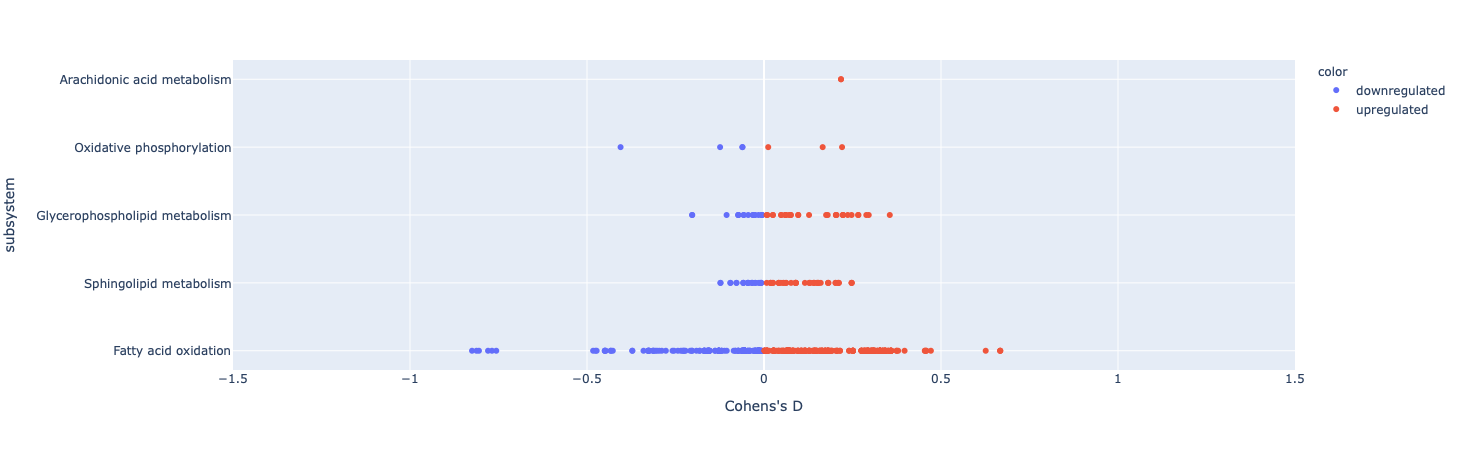

In [78]:
key = 'neurons'
plotly_category_plot(
    wilcoxon_test_results['single'],
    key + ' ' + ' vs. '.join(labels[key]),
    #relevant_subsystems
)

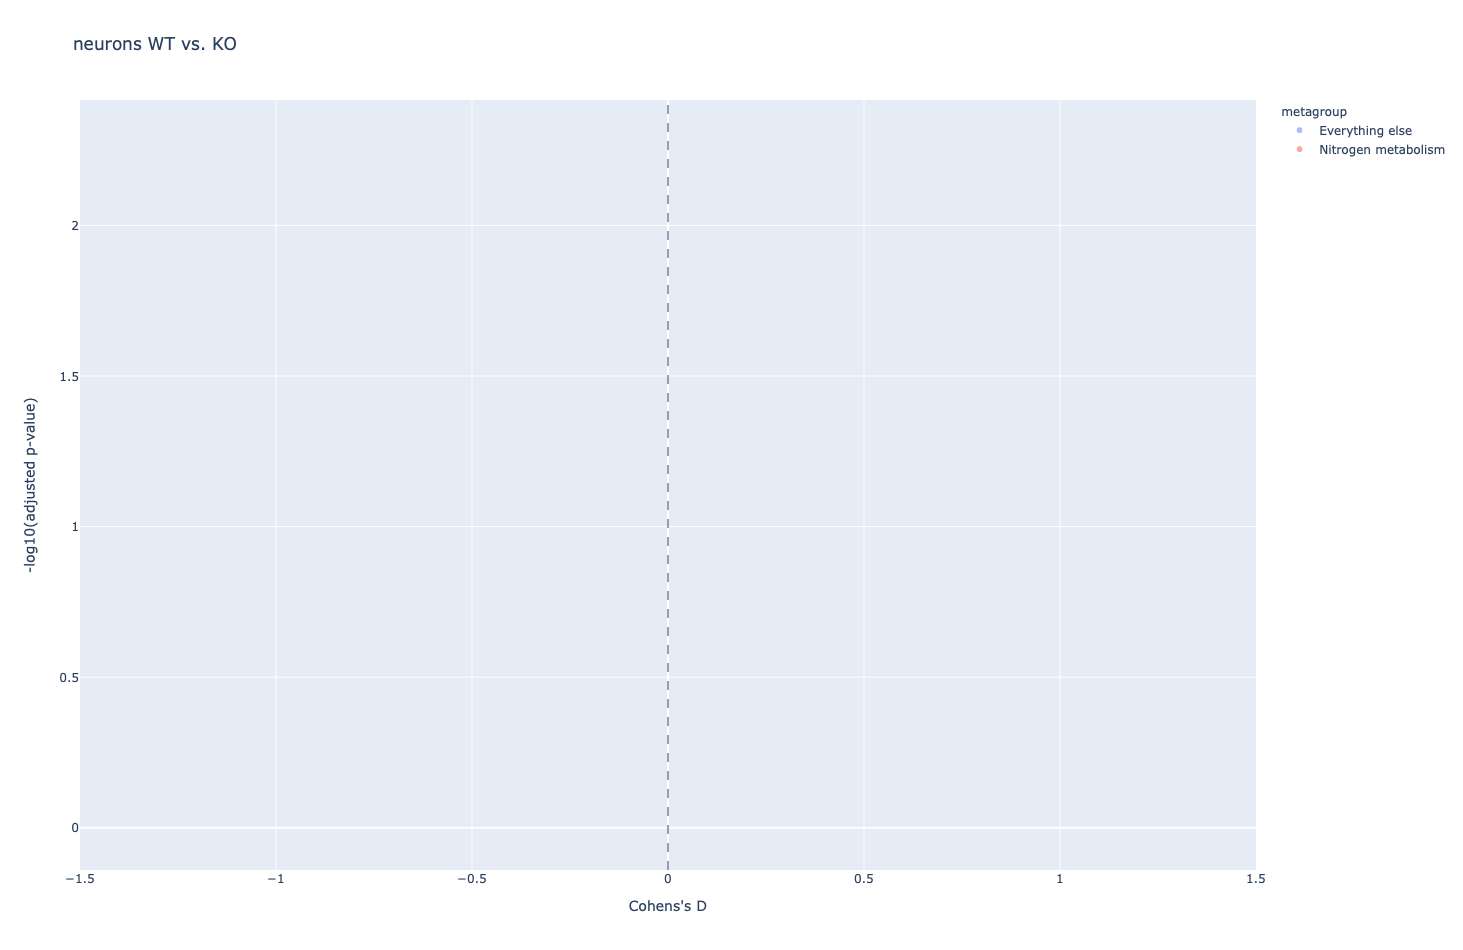

In [30]:
key = 'neurons'
plotly_vulcano_plot(
    wilcoxon_test_results['novarino_tpm'][key],
    key + ' ' + ' vs. '.join(labels[key]),
    color = 'metagroup',
    pval_cutoff = None,
    pval_column = 'wilcox_pval'
)

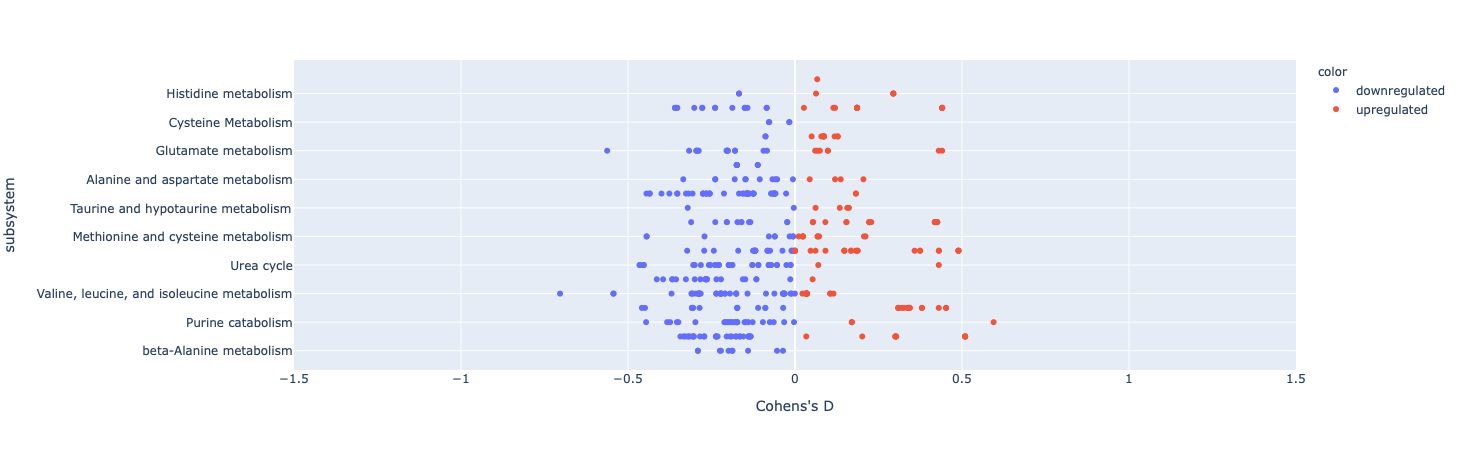

In [15]:
key = 'astrocytes'
plotly_category_plot(
    wilcoxon_test_results['novarino_tpm'][key],
    key + ' ' + ' vs. '.join(labels[key]),
    relevant_subsystems
)

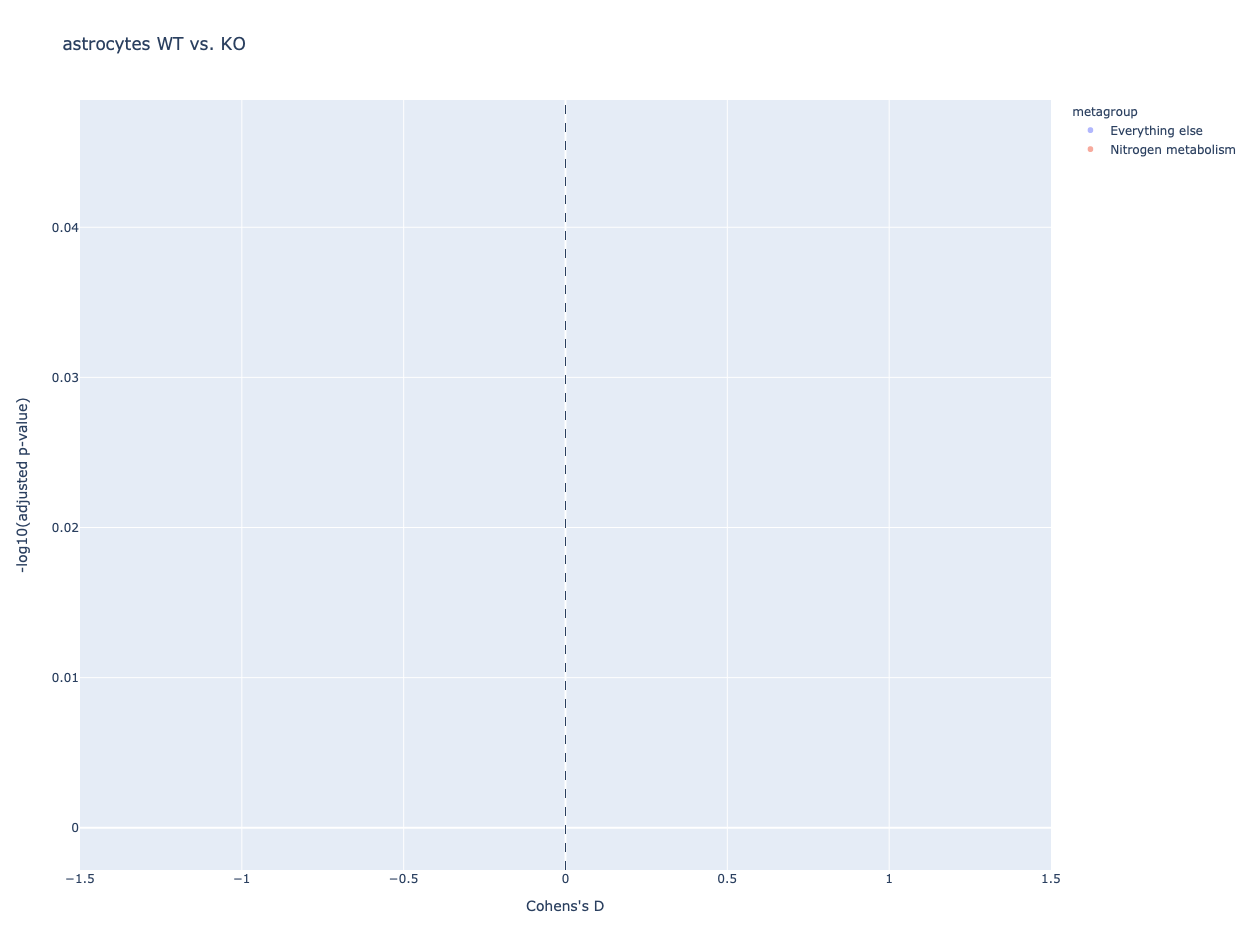

In [16]:
key = 'astrocytes'
plotly_vulcano_plot(
    wilcoxon_test_results['novarino_tpm'][key],
    key + ' ' + ' vs. '.join(labels[key]),
    pval_cutoff = None
)

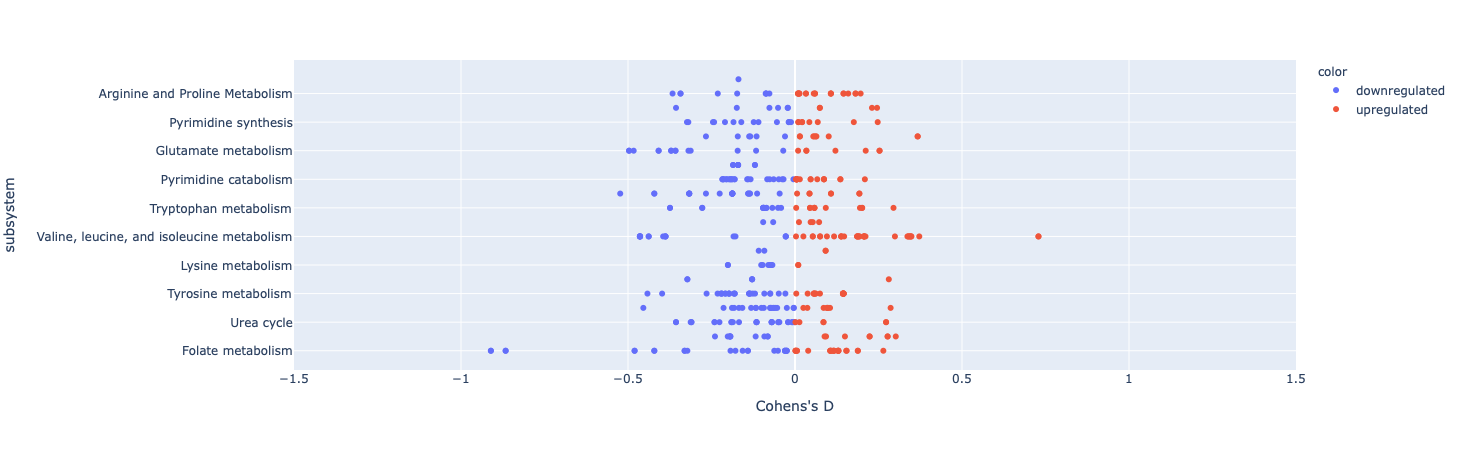

In [17]:
key = 'olfactory_cells'
plotly_category_plot(
    wilcoxon_test_results['novarino_tpm'][key],
    key + ' ' + ' vs. '.join(labels[key]),
    relevant_subsystems
)

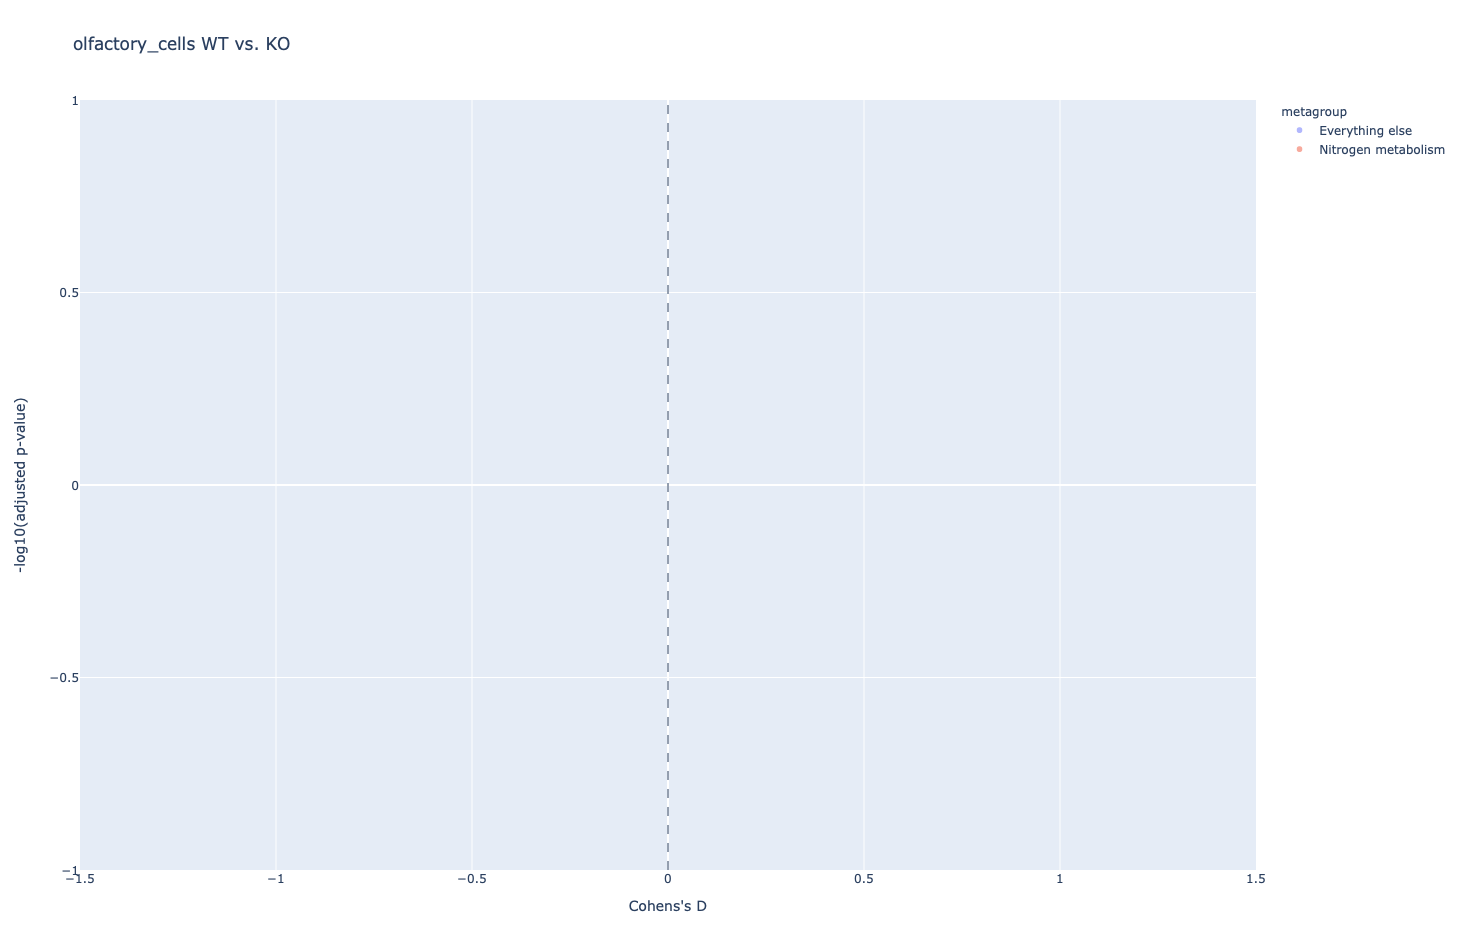

In [18]:
key = 'olfactory_cells'
plotly_vulcano_plot(
    wilcoxon_test_results['novarino_tpm'][key],
    key + ' ' + ' vs. '.join(labels[key]),
    pval_cutoff = None
)

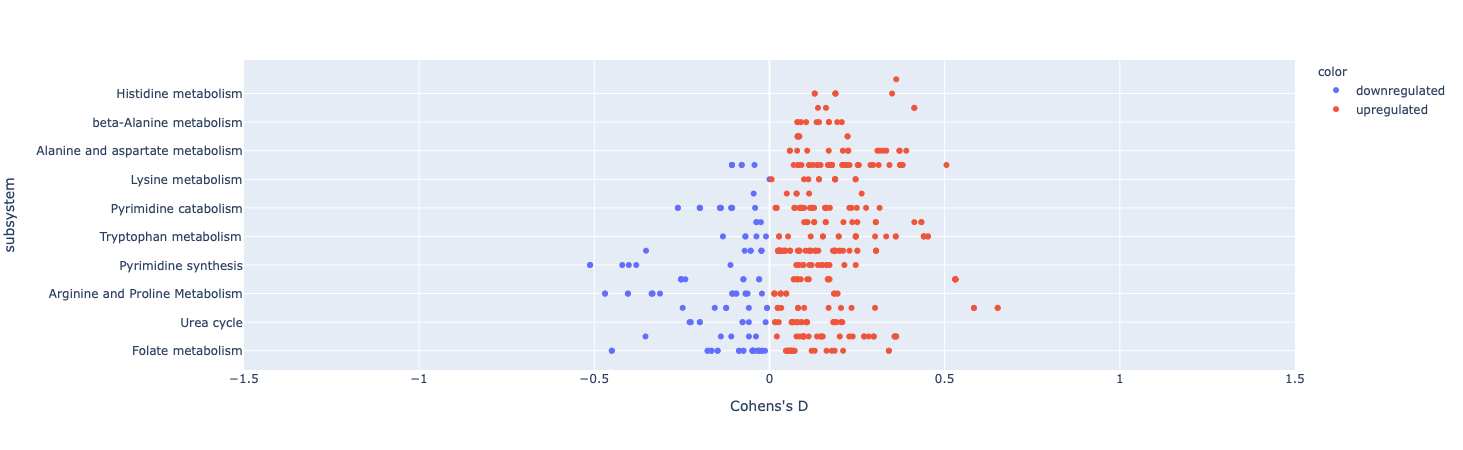

In [19]:
key = 'oligodendrytes'
plotly_category_plot(
    wilcoxon_test_results['novarino_tpm'][key],
    key + ' ' + ' vs. '.join(labels[key]),
    relevant_subsystems
)

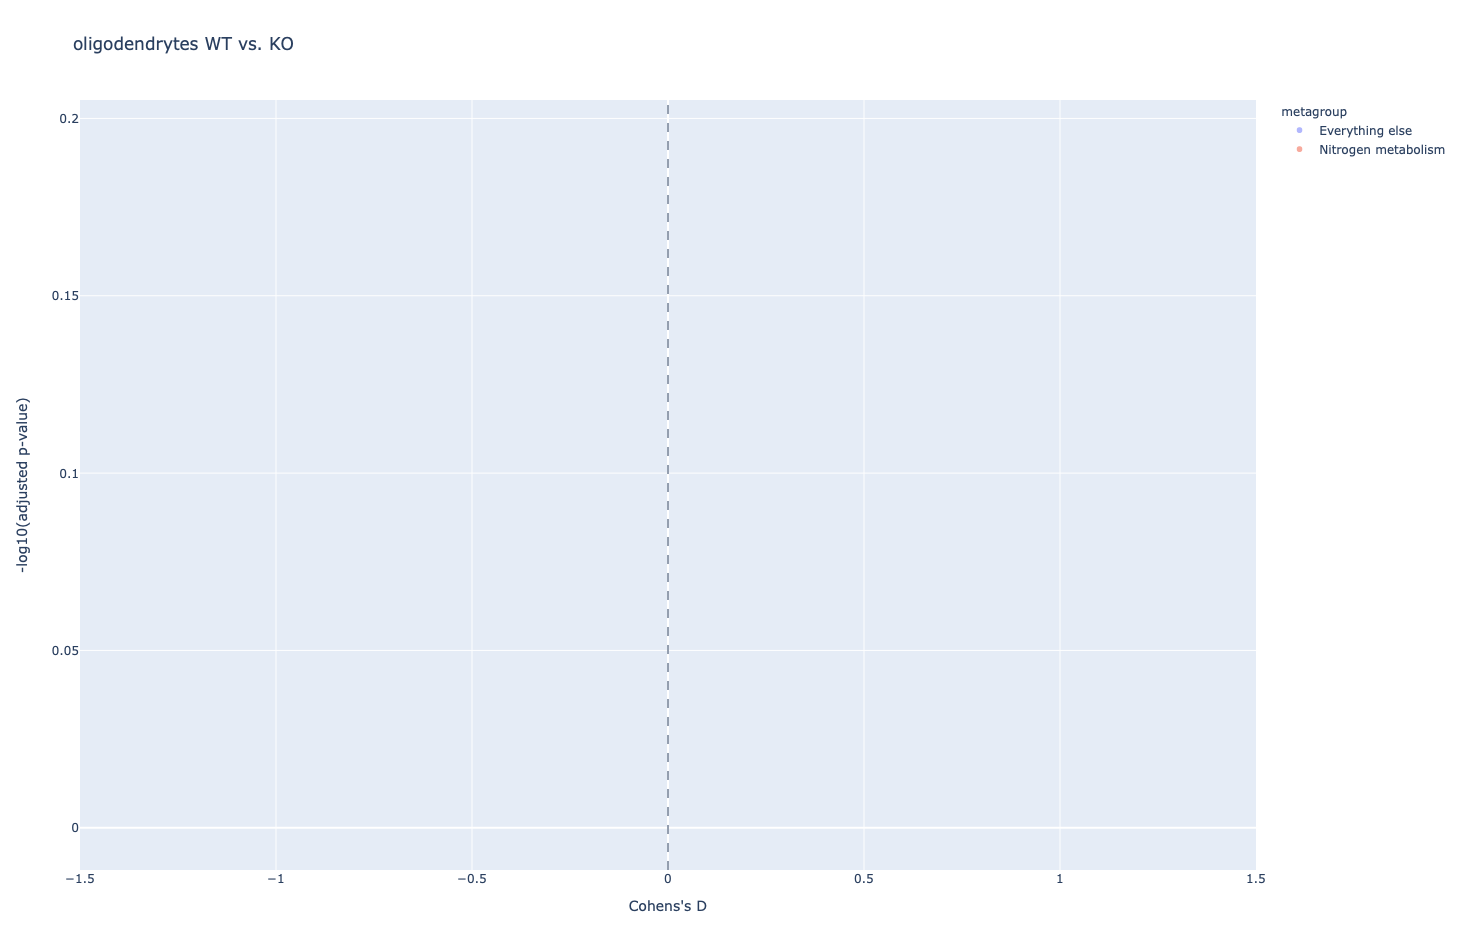

In [20]:
key = 'oligodendrytes'
plotly_vulcano_plot(
    wilcoxon_test_results['novarino_tpm'][key],
    key + ' ' + ' vs. '.join(labels[key]),
    pval_cutoff = None
)

## Bulk RNA results

In [21]:
bulk_quant = ['featureCounts_rna', 'salmon_rna']
reaction_bulk = {
    key: load_reactions(
        f'../compass/{key}/ko/reactions.tsv.gz',
        f'../compass/{key}/wt/reactions.tsv.gz',
        'KO', 'WT'
    ) for key in bulk_quant
}
bulk_consistencies = {
    key: get_reaction_consistencies(rcs) for key, rcs in reaction_bulk.items()
}
bulk_test_results = {}
for key, rcs in bulk_consistencies.items():
    disease_label, control_label = ['KO', 'WT']
    disease_clusters = rcs.columns[rcs.columns.str.startswith(disease_label)]
    control_clusters = rcs.columns[rcs.columns.str.startswith(control_label)]
    wilcox_results = wilcoxon_test(
        rcs, 
        disease_clusters, 
        control_clusters
    )
    wilcox_results['metadata_r_id'] = ""
    for r in wilcox_results.index:
        if r in reaction_metadata.index:
            wilcox_results.loc[r, 'metadata_r_id'] = r
        elif r[:-4] in reaction_metadata.index:
            wilcox_results.loc[r, 'metadata_r_id'] = r[:-4]
        else:
            print("Should not occur")

    W = wilcox_results.merge(
        reaction_metadata, 
        how = 'left',
        left_on = 'metadata_r_id', 
        right_index = True, 
        validate = 'm:1'
    )
    W = W.loc[~W.EC_number.isna(), :]
    W['metagroup'] = W.subsystem.apply(
        lambda x: 'Nitrogen metabolism' if x in relevant_subsystems else 'Everything else'
    )
    bulk_test_results[key] = W

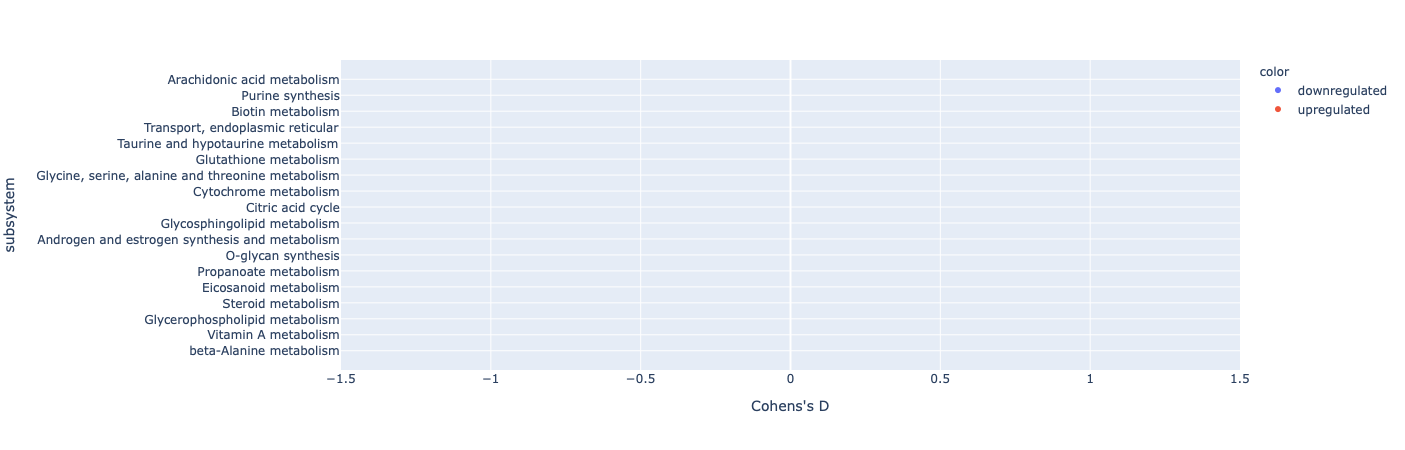

In [22]:
plotly_category_plot(
    bulk_test_results['salmon_rna'],
    key + ' ' + ' vs. '.join(['KO', 'WT']),
    #relevant_subsystems
)

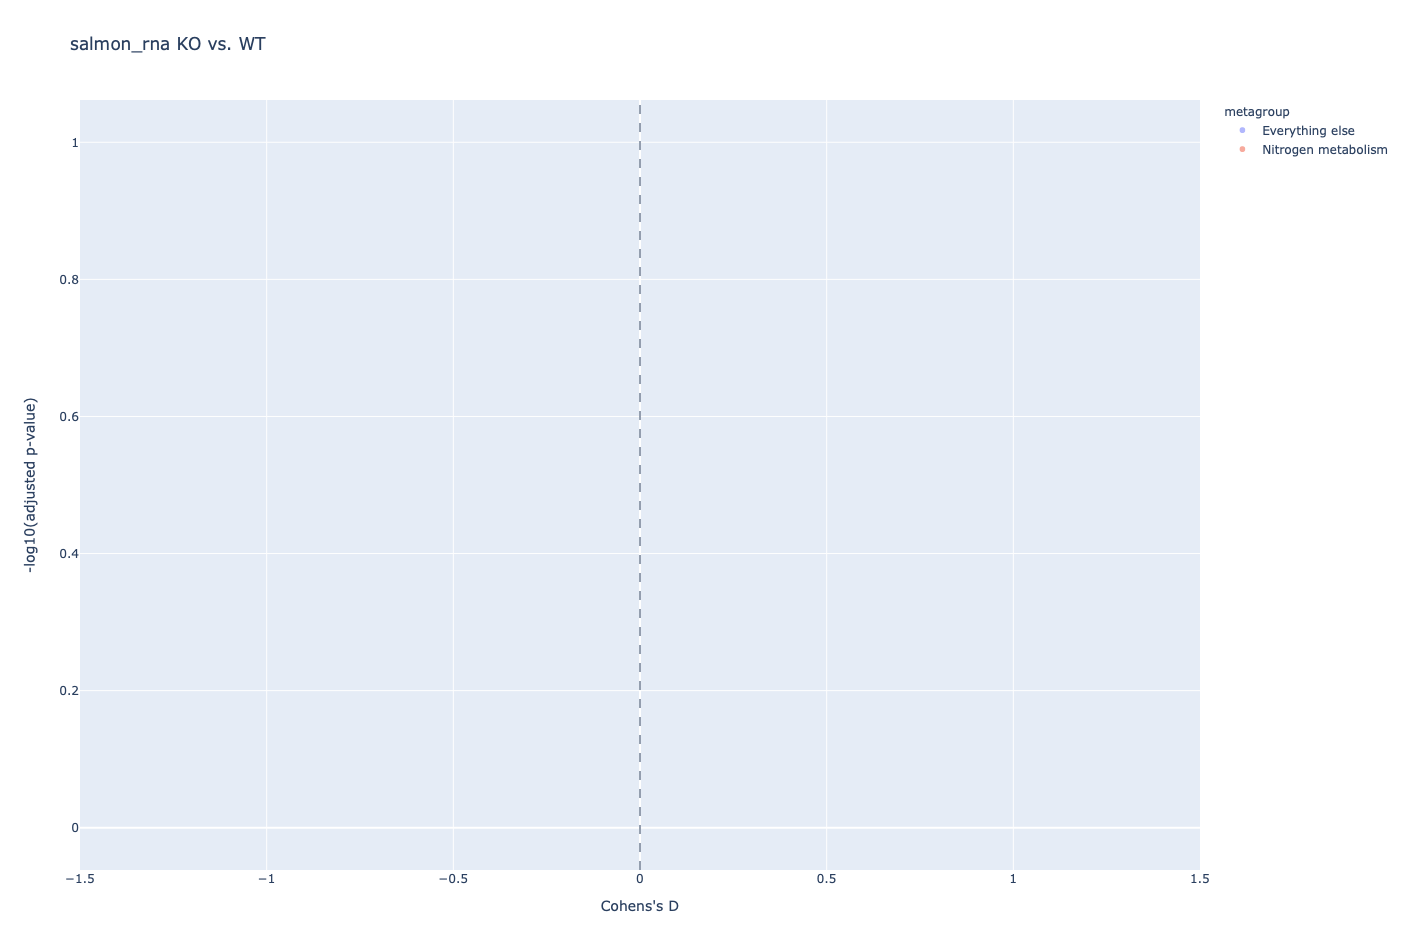

In [23]:
plotly_vulcano_plot(
    bulk_test_results['salmon_rna'],
    key + ' ' + ' vs. '.join(['KO', 'WT']),
    pval_cutoff = None,
    pval_column = 'wilcox_pval'
)

# Write results to file

In [30]:
df = reaction_consistencies['novarino_tpm']['neurons'].copy()
df['logFC'] = df.loc[:, df.columns.str.startswith('KO')].median(axis = 1) / df.loc[:, df.columns.str.startswith('WT')].median(axis = 1)
df = df.loc[:, ['logFC']]

for r in df.index:
    if r in reaction_metadata.index:
        df.loc[r, 'metadata_r_id'] = r
    elif r[:-4] in reaction_metadata.index:
        df.loc[r, 'metadata_r_id'] = r[:-4]
    else:
        print("Should not occur")
                
df['ec_number'] = df.metadata_r_id.apply(
    lambda x: reaction_metadata.at[x, 'EC_number']
)
df.dropna(
    subset = ['ec_number'],
    inplace = True
)
df = df.sort_index()
df

logFC     metadata_r_id ec_number
13DAMPPOX_pos         1.016497         13DAMPPOX   1.4.3.6
2DR1PP_pos            1.011031            2DR1PP  3.1.3.10
2HBO_neg              1.009523              2HBO  1.1.1.27
2HBO_pos              0.999164              2HBO  1.1.1.27
2OXOADOXm_pos         0.997916         2OXOADOXm  2.3.1.61
...                        ...               ...       ...
r1487_pos             1.030900             r1487   6.2.1.3
r1488_pos             1.017051             r1488   6.2.1.3
r1492_pos             1.030697             r1492   6.2.1.3
sink_citr(c)_pos      1.019971      sink_citr(c)  2.4.99.9
sink_pre_prot(r)_neg  0.999260  sink_pre_prot(r)  2.4.99.9

[2146 rows x 3 columns]

In [31]:
df.to_csv(
    '../raw/compass_results_neurons.tsv',
    sep = '\t'
)